<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/TF_GAN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Input Pipeline

In [0]:
def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)

  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
  
  if just_noise:
    return noise_ds
  
  def _preprocess(element):
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
                .map(_preprocess)
                .cache()
                .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
      buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
              .prefetch(tf.data.experimental.AUTOTUNE))
  
  return tf.data.Dataset.zip((noise_ds, images_ds))

## Download the data and sanity checks the inputs

Cause: could not parse the source code:

              .map(lambda _: tf.random.normal([bs, nd])))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


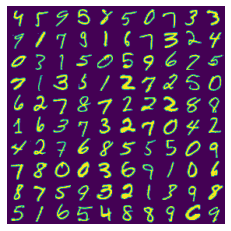

In [7]:
params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10,10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

## Neural Network Architecture
To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 

In [0]:
def _dense(inputs, units, l2_weight):
  return tf.compat.v1.layers.dense(inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))
  
def _batch_norm(inputs, is_training):
  return tf.compat.v1.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)
  
def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride],
      activation = tf.nn.relu, padding='same',
      kernel_initializer = tf.keras.initializers.glorot_uniform,
      kernel_regularizer = tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer = tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides = [stride, stride],
      activation = None, padding='same',
      kernel_initializer = tf.keras.initializers.glorot_uniform,
      kernel_regularizer = tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer = tf.keras.regularizers.l2(l=l2_weight))

### Generator

In [0]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)

  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)

  net = _dense(net, 7*7*256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)

  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

### Discriminator

In [0]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)

  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)

  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)

  net = tf.compat.v1.layers.flatten(net)

  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)

  net = _dense(net, 1, weight_decay)

  return net

## Evaluating Generative Models and GANs
TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al for more information about the Inception Score.

*Frechet Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al for more information about the Frechet Inception distance.

In [0]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
      'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.compat.v1.metrics.mean(real_mnist_score),
      'mnist_score': tf.compat.v1.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.compat.v1.metrics.mean(frechet_distance)}

## GANEstimator

In [0]:
train_batch_size = 32
noise_dimensions = 64
generator_lr = 0.001
discriminator_lr = 0.0002

def gen_opt():
  gstep = tf.compat.v1.train.get_or_create_global_step()
  base_lr = generator_lr
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.compat.v1.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn = unconditional_generator,
    discriminator_fn = unconditional_discriminator,
    generator_loss_fn = tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn = tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer = gen_opt,
    discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

## Train and eval loop

Time since start: 0.00 min
Trained from step 0 to 500 in 178374.76 steps / sec
Average discriminator output on Real: 112.95 Fake: 96.68
Inception Score: 7.62 / 8.35 Frechet Distance: 59.43


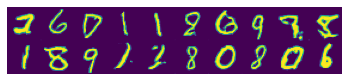

Time since start: 0.08 min
Trained from step 500 to 1000 in 172903.95 steps / sec
Average discriminator output on Real: 112.95 Fake: 96.94
Inception Score: 7.56 / 8.35 Frechet Distance: 60.52


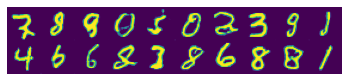

Time since start: 0.16 min
Trained from step 1000 to 1500 in 206636.32 steps / sec
Average discriminator output on Real: 112.95 Fake: 97.73
Inception Score: 7.59 / 8.35 Frechet Distance: 57.55


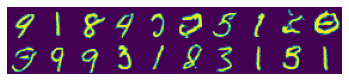

Time since start: 0.23 min
Trained from step 1500 to 2000 in 193678.61 steps / sec
Average discriminator output on Real: 112.95 Fake: 96.80
Inception Score: 7.51 / 8.35 Frechet Distance: 62.03


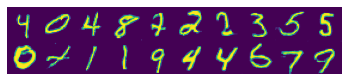

Time since start: 0.31 min
Trained from step 2000 to 2500 in 170958.83 steps / sec
Average discriminator output on Real: 112.95 Fake: 95.94
Inception Score: 7.52 / 8.35 Frechet Distance: 55.48


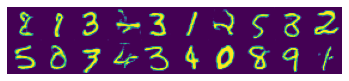

Time since start: 0.38 min
Trained from step 2500 to 3000 in 204780.00 steps / sec
Average discriminator output on Real: 112.95 Fake: 97.71
Inception Score: 7.67 / 8.35 Frechet Distance: 57.71


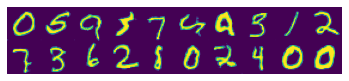

Time since start: 0.47 min
Trained from step 3000 to 3500 in 156749.53 steps / sec
Average discriminator output on Real: 112.95 Fake: 96.39
Inception Score: 7.57 / 8.35 Frechet Distance: 58.85


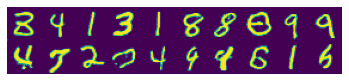

Time since start: 0.55 min
Trained from step 3500 to 4000 in 191888.74 steps / sec
Average discriminator output on Real: 112.95 Fake: 96.80
Inception Score: 7.67 / 8.35 Frechet Distance: 57.13


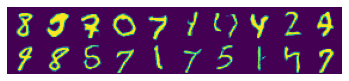

Time since start: 0.62 min
Trained from step 4000 to 4500 in 183285.44 steps / sec
Average discriminator output on Real: 112.95 Fake: 97.19
Inception Score: 7.61 / 8.35 Frechet Distance: 58.49


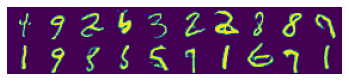

Time since start: 0.70 min
Trained from step 4500 to 5000 in 198857.58 steps / sec
Average discriminator output on Real: 112.95 Fake: 97.11
Inception Score: 7.57 / 8.35 Frechet Distance: 60.47


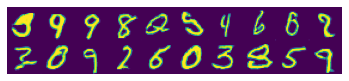

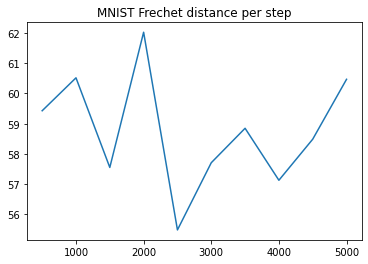

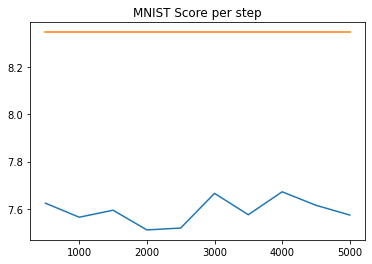

In [22]:
# Disable noisy output
tf.compat.v1.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500
max_train_steps = 5000
batches_for_eval_metrics = 100

# Used to track metrics
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print("Time since start: %.2f min" % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step

  # Calculate some metrics
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print("Average discriminator output on Real: %.2f Fake: %.2f" % (
      real_logits[-1], fake_logits[-1]))
  print("Inception Score: %.2f / %.2f Frechet Distance: %.2f" % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Visualize some images
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.compat.v1.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs,grid_shape=(2,10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()

# Plot metrics vs step
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title("MNIST Score per step")
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()